# Harris_corner_detection

### Harris Corner Detection in openCV

OpenCV has the function cv.cornerHarris() for this purpose. Its arguments are:  
* img - Input image. It should be grayscale and float32 type.
* blockSize - It is the size of neighbourhood considered for corner detection
* ksize - Aperture parameter of the Soble derivative used.
* K = Harris detector free parameter in the equation.

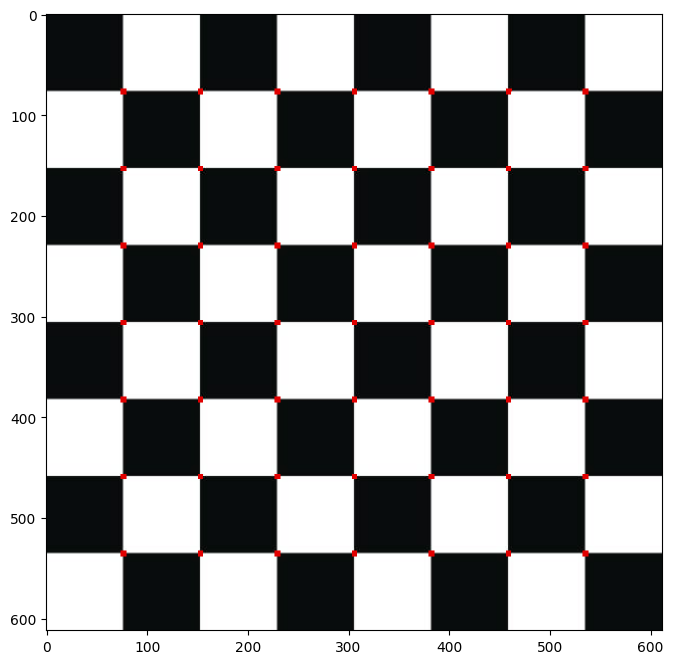

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

filename = '../chapter_2/Chapter_2.0/data/chessboard.jpg'
img = cv.imread(filename)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)

# result is dilated for marking the corners, not important
dst = cv.dilate(dst, None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()] = [0,0,225]
# cv.imshow('dst', img)
# if cv.waitKey(0) & 0xff == 27:
#   cv.destoryAllWindows()
plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()    

# Using Kornia library

torch.Size([1, 1, 612, 612])


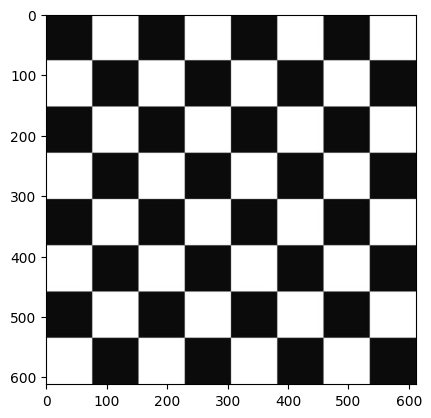

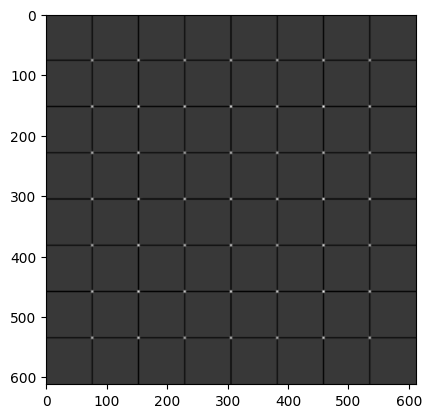

In [2]:
import torch
from torchvision import transforms
import kornia.feature as KF

from PIL import Image

filename = '../chapter_2/Chapter_2.0/data/chessboard.jpg'

tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0)

print(tensor.shape)

plt.imshow(tensor.squeeze(), cmap='gray')
plt.show()

harris = KF.responses.CornerHarris(0.05)

cornerness = harris(tensor)

plt.imshow(cornerness.squeeze(), cmap='gray')
plt.show()

# (심화) Example on the scale pyramid

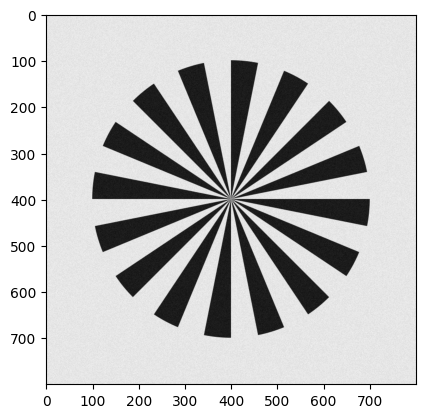

In [3]:
import kornia
import kornia.geometry as KG
from kornia import tensor_to_image as tti
from PIL import Image

# ScalePyramid create spyramid of blurred and (downsampes images
# SP = KG.ScalePyramid(3, 1.6, 10)
SP = KG.ScalePyramid(3, 1.0, 1.0)

filename = '../chapter_2/Chapter_2.0/data/siemens.png'

img = Image.open(filename) #.convert('L')

timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() /255. /255.

plt.imshow(kornia.utils.tensor_to_image(timg[0]), 'gray')

7 torch.Size([1, 1, 6, 800, 800])


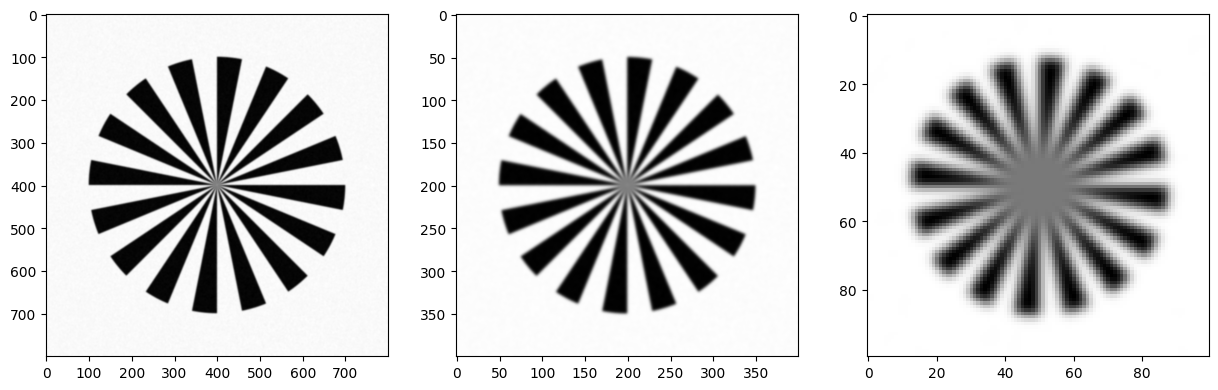

In [4]:
resp = KF.responses.CornerHarris(0.05)

SP = KG.ScalePyramid(3, 1.6, 10)

pyr, sigmas, scales = SP(timg)
print(len(pyr), pyr[0].shape)

fig, axes = plt.subplots(1,3, figsize=(15, 8))

ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]), 'gray')
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]), 'gray')
ax = axes[2]
ax.imshow(tti(pyr[3][0,0,0]), 'gray')
current_level = pyr[1]

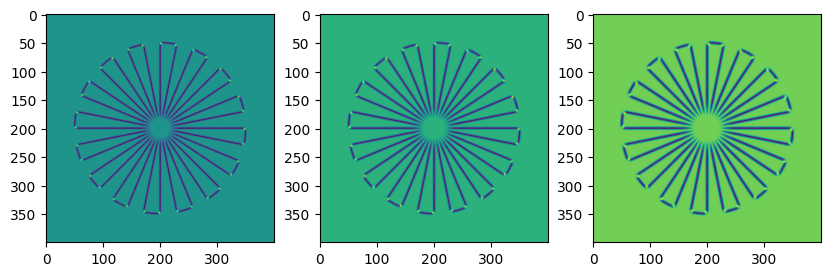

In [5]:
fig, axes = plt.subplots(1,3, figsize=(10, 6))

cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0,i]))

In [6]:
## The next component is detector of the maximum of the local responce: ConvQuadInterp3d(),
## which dose quadratic interpolation of the location, or ConvSoftArgmax3d,
## which dose softargmax estimation of the location.

nmsl = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                        stride=(1,1,1), # stride (scale, height, width)
                                        padding=(1,1,1),
                                        temperature=0.1)

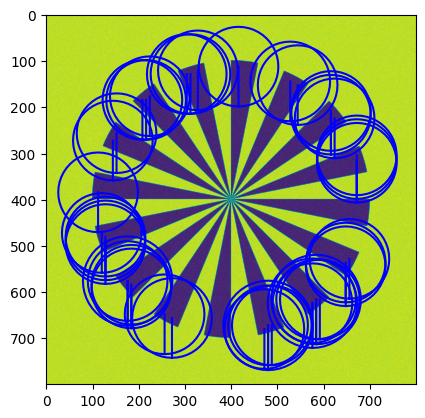

torch.Size([1, 40, 2, 3])


In [7]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'b')
    plt.show()
    return

# Lets detect Harris corners
n_feats = 40
mr_size = 6.0

harris_local_dectector = KF.ScaleSpaceDetector(n_feats,
                                               resp_module=resp,
                                               nms_module=nmsl,
                                               mr_size=mr_size)

lafs, resps = harris_local_dectector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

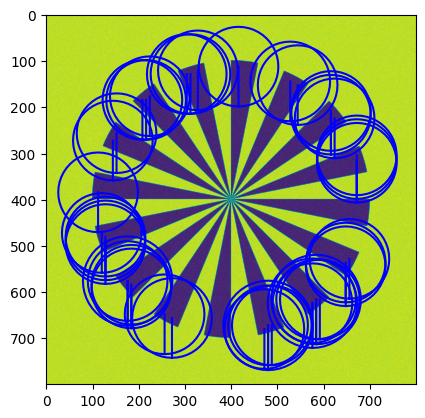

torch.Size([1, 40, 2, 3])


In [8]:
# n_feats = 40
mr_size = 6.0
nmsl = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3),
                                        stride=(1,1,1),
                                        padding=(1,1,1),
                                        temperature=0.1,
                                        strict_maxima_bonus=100.)

harris_local_dectector = KF.ScaleSpaceDetector(n_feats,
                                               resp_module=resp,
                                               nms_module=nmsl,
                                               mr_size=mr_size)

lafs, resps = harris_local_dectector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

생각보다 duplication(중복 데이터) 제거가 잘 안된다.  
따라서, quadrative interporlation 3D를 통해 subpixel 수준에서의 non-maximal suppression을 한 번 더 수행한다.

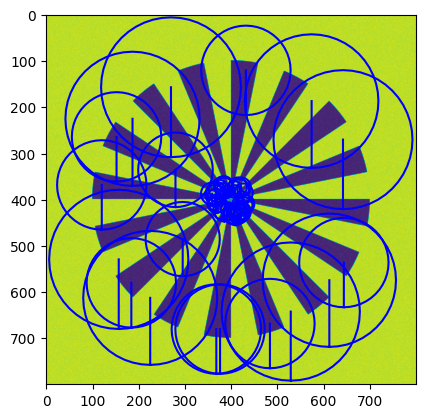

torch.Size([1, 50, 2, 3])


In [9]:
# Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4)

harris_local_dectector = KF.ScaleSpaceDetector(n_feats,
                                               resp_module=resp,
                                               nms_module=nms,
                                               mr_size=mr_size)

lafs, resps = harris_local_dectector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

Harris 가 아니라 다른 affine 모듈 (e.g., DoG, LoG를 사용)은 어떻게 될까?  
scale-space detector에 shape estimator를 넣어서 실행.

C:\Users\user\AppData\Local\Temp\ipykernel_7256\2114255165.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


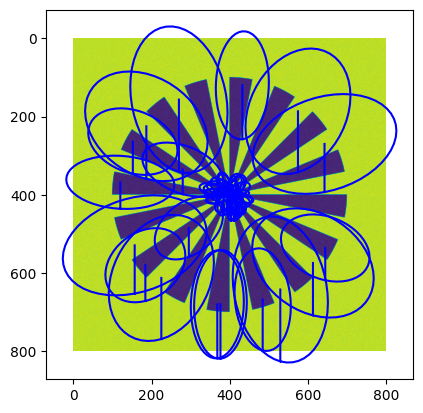

torch.Size([1, 50, 2, 3])


In [10]:
# What about Harris-Affine features?
harris_affine_local_dector = KF.ScaleSpaceDetector(n_feats,
                                                   resp_module=kornia.feature.CornerHarris(0.05),
                                                   nms_module=nms,
                                                   mr_size=mr_size,
                                                   aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                                   minima_are_also_good=False)
lafs, resps = harris_affine_local_dector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)

Feature orientation estimator도 추가 가능

C:\Users\user\AppData\Local\Temp\ipykernel_7256\1912314171.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


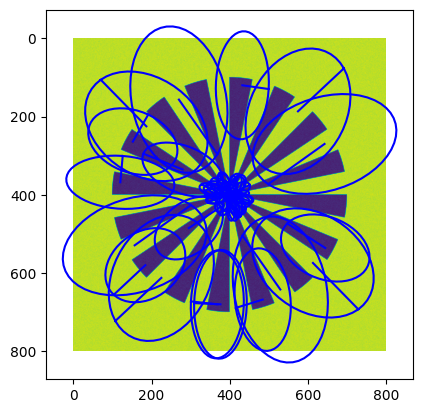

In [11]:
# Now lets also detect feature orientation
harris_affine_local_dector = KF.ScaleSpaceDetector(n_feats,
                                                   resp_module=kornia.feature.CornerHarris(0.05),
                                                   nms_module=nms,
                                                   mr_size=mr_size,
                                                   aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                                   ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_dector(timg)
visualize_LAF(timg, lafs)

In [12]:
# Lets describe patches with SIFT descriptor
descriptor = KF.SIFTDescriptor(32)

patches = kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standrad tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :)
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print(descs.shape)
print(descs[0,0])

torch.Size([1, 50, 128])
tensor([1.3893e-01, 2.0053e-01, 1.4998e-01, 6.3287e-02, 1.5847e-01, 2.0053e-01,
        9.4211e-02, 1.5585e-01, 2.5031e-02, 1.6963e-01, 4.3598e-02, 5.7787e-02,
        6.7225e-03, 9.0073e-03, 9.9875e-03, 6.6360e-03, 1.7291e-01, 7.3110e-02,
        6.3612e-03, 7.9669e-03, 2.0053e-01, 1.7463e-02, 2.9080e-02, 8.5291e-02,
        3.7065e-02, 1.4527e-01, 7.2607e-02, 1.1722e-01, 7.4506e-03, 8.6638e-03,
        8.8369e-03, 9.9296e-03, 3.1557e-02, 5.4754e-03, 2.0778e-02, 4.9841e-02,
        2.4150e-02, 2.0259e-03, 3.9832e-02, 6.9763e-02, 1.0912e-01, 2.0053e-01,
        1.3531e-01, 1.0808e-01, 1.0402e-02, 1.0404e-02, 8.3176e-03, 9.3518e-03,
        1.1230e-02, 6.8468e-02, 1.4991e-01, 2.0053e-01, 6.3103e-03, 2.3799e-02,
        1.8712e-01, 1.2578e-01, 8.0860e-02, 4.7910e-02, 1.2006e-01, 1.1184e-02,
        1.0251e-02, 1.0076e-02, 7.9999e-03, 8.2897e-03, 1.0547e-01, 2.0004e-01,
        1.7103e-01, 5.2732e-02, 1.5447e-01, 1.6644e-01, 2.0053e-01, 2.3338e-02,
        1.4738e